# CNN

## 1. Imports

### 1.1 Setup for Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
 cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [26]:
ls

backup_removed_files/        RGB/     Thermal/     trainingResults/
CNN_EarlyFusion_Final.ipynb  RgbAug/  ThermalAug/  wandb/


### 1.2 Install Depedencies

In [27]:
#install dependencies
# !pip install -r requirements.txt

In [28]:
import os
import copy
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms,models
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import pandas as pd
import wandb
import time
from datetime import datetime

### 1.2 Global Variables

In [29]:
EPOCHS = 30
CLASSES = 7
BATCH_SIZE = 64
NUM_WORKERS = 4 # change based on specification of computer
LEARNING_RATE = 0.001

In [41]:
wandb.init(
    project="multimodal_cnn",
    name="early_fusion_cnn",
    mode="offline",
    config={
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "model": "CNN Early Fusion",
        "fusion_type": "addition"
    }
)

## 2. Load Data and Split

In [32]:
#directories
rgbDir = ['RGB','RgbAug']
thermalDir = ['Thermal','ThermalAug']

### 2.1 Single Modality

In [33]:
def loadDataSingleModality(modalDir):
    '''
    Loads and processes data from a single modality (either RGB or Thermal).
    Args:
        modalDir (list): List containing two directory paths - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of all image file paths.
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''

    #get list of files in the directory and combine them
    pairedFiles = []
    for data in modalDir:
        pairedFiles.extend(glob.glob(os.path.join(data, "*")))
    pairedFiles = sorted(pairedFiles)

    print(f'Total files: {len(pairedFiles)}')


    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in pairedFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For single modality testing (using raw and augmented data together)

#change this to test either thermal or rgb
modalDir = rgbDir

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataSingleModality(modalDir)

#for saving results later
if modalDir == rgbDir:
    savingLabel = "RGB"
else:
    savingLabel = "Thermal"

Total files: 20675
Data arranged as: tensor([0, 0, 0,  ..., 6, 6, 6])

Sample output:
File: RGB/R_Angry_10_KTFE.jpg
Label: Angry



### 2.2 Multi Modality

In [34]:
def loadDataMultiModality(rgbDir,thermalDir):
    '''
    Loads and processes data from both RGB and Thermal modalities.
    Args:
        rgbDir (list): List containing two directory paths for RGB images - first for raw images, second for augmented images.
        thermalDir (list): List containing two directory paths for Thermal images - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of tuples, each containing a pair of (RGB image path, Thermal image path).
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''


    #get list of files in the directory and combine them
    rgbFiles = []
    thermalFiles = []
    for data in rgbDir:
        rgbFiles.extend(glob.glob(os.path.join(data, "*")))
    for data in thermalDir:
        thermalFiles.extend(glob.glob(os.path.join(data, "*")))

    #pairs thermal and rgb files together
    pairedFiles = list(zip(rgbFiles, thermalFiles))
    print(f"Total pairs: {len(pairedFiles)}")

    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in thermalFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)

    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)

    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For multi modality testing (using raw and augmented data together)

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataMultiModality(rgbDir,thermalDir)


Total pairs: 20675
Data arranged as: tensor([5, 5, 5,  ..., 0, 0, 0])

Sample output:
File: ('RGB/R_Sad_2002_KTFE.jpg', 'Thermal/T_Sad_2117_KTFE.jpg')
Label: Sad



### 2.3 Split Data
- 80:20

In [35]:

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    pairedFiles, tensorLabels,
    test_size=0.2,
    stratify=tensorLabels,
    random_state=42
)
print(f'Train size: {len(X_train)}\nTest size: {len(X_test)}')

Train size: 16540
Test size: 4135


In [36]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## 3. DataLoader

### 3.1 Single Modality

In [37]:
class SingleModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        imagePath = self.pairedFiles[idx]
        image = Image.open(imagePath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


train_dataset = SingleModalImageDataset(X_train, y_train, transform=transform)
test_dataset = SingleModalImageDataset(X_test, y_test, transform=transform)

### 3.2 Multi Modality

In [38]:
class MultiModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        rgbPath,thermalPath  = self.pairedFiles[idx]
        rgb = Image.open(rgbPath).convert('RGB')
        thermal = Image.open(thermalPath).convert('RGB') #try L greyscale

        if self.transform:
            rgb = self.transform(rgb)
            thermal = self.transform(thermal)

        label = self.labels[idx]
        return (rgb,thermal),label

train_dataset = MultiModalImageDataset(X_train, y_train, transform=transform)
test_dataset = MultiModalImageDataset(X_test, y_test, transform=transform)

### 3.3 Train and Test Loader

In [39]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

## 4. ShuffleNet V.2

### 4.1 Single Modality

In [ ]:
#device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

#initialise model
model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, CLASSES)
model.to(device)

#loss function and optimiser
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

#to collect data for plotting later
trainLosses = []
testAccuracies = []
predictionsArr = []
targetsArr = []

##Training
for epoch in range(EPOCHS):
    model.train()
    runningTrain = 0
    #progress bar
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        x, y = x.to(device), y.to(device)
        optimiser.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimiser.step()
        #batch loss calculation
        runningTrain += loss.item() * x.size(0)
    trainLoss = runningTrain / len(train_loader.dataset)

    ##Evaluation
    model.eval()
    accPre = 0
    totalDatapoints = 0
    #progress bar
    for input, target in tqdm(test_loader, desc=f"Epoch {epoch+1} Evaluating"):
        input, target = input.to(device), target.to(device)
        with torch.no_grad():
            outputs = model(input)
            #accuracy calculation
            predicted = outputs.argmax(1)

            #https://medium.com/@heyamit10/building-a-multiclass-classification-model-in-pytorch-a-detailed-practical-guide-b03fc93aa400
            predictionsArr.extend(predicted.cpu().numpy())
            targetsArr.extend(target.cpu().numpy())

            accPre += (predicted == target).sum().item()
            totalDatapoints += target.size(0)
    finalAcc = accPre / totalDatapoints

    trainLosses.append(trainLoss)
    testAccuracies.append(finalAcc)


    #prints each epoch's results
    print(f"Epoch {epoch+1}: Train Loss = {trainLoss:.4f}, Test Accuracy = {finalAcc:.4f}")


### 4.2 Multi Modality

In [43]:
class EarlyFusionFER(nn.Module):
    """
    Early Fusion CNN using concatenation fusion type

    """

    def __init__(self, num_classes: int = 7, fusion_type: str = "concat"):
        """
        Args:
            num_classes: Number of emotion classes (7 for FER)
            fusion_type: How to fuse RGB and Thermal ("concat" or "add")
        """
        super().__init__()

        self.num_classes = num_classes
        self.fusion_type = fusion_type

        # Determine input channels
        if fusion_type == "concat":
            input_channels = 6
        else:  # add
            input_channels = 3

        # Load pre-trained ShuffleNet V2
        self.model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)


        # Reference adapt from PyTorch Forums discussion on changing input channels for pretrained models
        # https://discuss.pytorch.org/t/how-to-change-no-of-input-channels-to-a-pretrained-model/19379
        # https://discuss.pytorch.org/t/transfer-learning-how-to-modify-the-first-conv2d-layer-of-alexnet-to-accomodate-for-9-channel-input/4063

        # Modify first conv layer for multimodal input
        if input_channels != 3:
            # Original first conv layer
            original_conv = self.model.conv1[0]

            new_conv = nn.Conv2d(
                # New number of input channels
                input_channels,
                # Keep original output channels
                original_conv.out_channels,
                # Same kernel size
                kernel_size=original_conv.kernel_size,
                stride=original_conv.stride,
                padding=original_conv.padding,
                bias=original_conv.bias is not None
            )

            # Initialise new conv weights
            with torch.no_grad():
                if input_channels == 6:  # concat case
                    new_conv.weight[:, :3, :, :] = original_conv.weight  # RGB channels
                    new_conv.weight[:, 3:6, :, :] = original_conv.weight  # Thermal channels

                if original_conv.bias is not None:
                    new_conv.bias.copy_(original_conv.bias)

            # Replace the first conv layer
            self.model.conv1[0] = new_conv

        # Replace the final classifier to match num_classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, rgb_images, thermal_images):
        """
        Forward pass

        Args:
            rgb_images: RGB images tensor (B, 3, H, W)
            thermal_images: Thermal images tensor (B, 3, H, W)

        Returns:
            Logits tensor (B, num_classes)
        """

        # Ensure both images are on the same device
        device = rgb_images.device
        thermal_images = thermal_images.to(device)

        # Fuse RGB and Thermal at input level
        if self.fusion_type == "concat":   # concat
            fused_input = torch.cat([rgb_images, thermal_images], dim=1)  # (B, 6, H, W) 6 channels
        else:  # add
            # Element-wise addition approach - preserves 3-channel input
            fused_input = rgb_images + thermal_images


        # Forward pass through ShuffleNet
        return self.model(fused_input) # Returns logits (B, num_classes)


# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialise multimodal model
model = EarlyFusionFER(num_classes=CLASSES, fusion_type="concat")
model.to(device)

# Loss function and optimiser
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# To collect data for plotting later
trainLosses = []
testAccuracies = []
predictionsArr = []
targetsArr = []

# For saving results
savingLabel = "MultiModal_EarlyFusion"


# Training timing setup
print("Starting training...")
training_start_time = time.time()
training_start_datetime = datetime.now()
print(f"Training started at: {training_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

## Training
for epoch in range(EPOCHS):
    # add start time
    epoch_start_time = time.time()
    model.train()
    runningTrain = 0

    # Training loop
    for (rgb, thermal), y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        rgb, thermal, y = rgb.to(device), thermal.to(device), y.to(device)
        optimiser.zero_grad()

        # Forward pass
        outputs = model(rgb, thermal)
        loss = criterion(outputs, y)

        loss.backward()
        optimiser.step()

        # Accumulate batch loss
        runningTrain += loss.item() * rgb.size(0)

    # Calculate epoch training loss (once per epoch)
    trainLoss = runningTrain / len(train_loader.dataset)

    ## Evaluation
    model.eval()
    accPre = 0
    totalDatapoints = 0

    for (rgb, thermal), target in tqdm(test_loader, desc=f"Epoch {epoch+1} Evaluating"):
        rgb, thermal, target = rgb.to(device), thermal.to(device), target.to(device)
        with torch.no_grad():
            outputs = model(rgb, thermal)
            predicted = outputs.argmax(1)

            # Collect predictions and targets
            predictionsArr.extend(predicted.cpu().numpy())
            targetsArr.extend(target.cpu().numpy())

            accPre += (predicted == target).sum().item()
            totalDatapoints += target.size(0)

    finalAcc = accPre / totalDatapoints
    trainLosses.append(trainLoss)
    testAccuracies.append(finalAcc)

    # Calculate epoch time
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # Calculate elapsed training time
    elapsed_time = epoch_end_time - training_start_time

    # Combined wandb log (train loss, test accuracy, GPU usage, timing)
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": trainLoss,
        "test_accuracy": finalAcc,
        "gpu_memory_allocated_GB": torch.cuda.memory_allocated() / 1e9,
        "gpu_memory_reserved_GB": torch.cuda.memory_reserved() / 1e9,
        "epoch_duration_minutes": epoch_duration / 60,
        "total_elapsed_time_minutes": elapsed_time / 60
    })

    # Print results with timing
    print(f"Epoch {epoch+1}: Train Loss = {trainLoss:.4f}, Test Accuracy = {finalAcc:.4f}, "
          f"Epoch Time = {epoch_duration/60:.2f} min, Total Time = {elapsed_time/60:.2f} min")


# Training completion timing
training_end_time = time.time()
training_end_datetime = datetime.now()
total_training_time = training_end_time - training_start_time


# Final results with timing information
print(f"\n" + "="*60)
print(f"Training completed..")
print(f"="*60)
print(f"Training started at:  {training_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training ended at:    {training_end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time:  {total_training_time/3600:.2f} hours ({total_training_time/60:.2f} minutes)")

# Final results
print(f"\nFinal Results:")
print(f"Best Test Accuracy: {max(testAccuracies):.4f}")
print(f"Final Test Accuracy: {testAccuracies[-1]:.4f}")


# Log final timing to wandb
wandb.log({
    "total_training_time_hours": total_training_time / 3600,
    "total_training_time_minutes": total_training_time / 60,
    "best_test_accuracy": max(testAccuracies),
    "final_test_accuracy": testAccuracies[-1]
})

wandb.finish()

Starting training...
Training started at: 2025-08-30 09:50:23


Epoch 1 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.68it/s]


Epoch 1: Train Loss = 1.0136, Test Accuracy = 0.7311, Epoch Time = 1.46 min, Total Time = 1.46 min


Epoch 2 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.67it/s]


Epoch 2: Train Loss = 0.4569, Test Accuracy = 0.8428, Epoch Time = 1.47 min, Total Time = 2.93 min


Epoch 3 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.67it/s]


Epoch 3: Train Loss = 0.2642, Test Accuracy = 0.8537, Epoch Time = 1.48 min, Total Time = 4.41 min


Epoch 4 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.54it/s]


Epoch 4: Train Loss = 0.1927, Test Accuracy = 0.8815, Epoch Time = 1.47 min, Total Time = 5.88 min


Epoch 5 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.70it/s]


Epoch 5: Train Loss = 0.1289, Test Accuracy = 0.8909, Epoch Time = 1.46 min, Total Time = 7.34 min


Epoch 6 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.52it/s]


Epoch 6: Train Loss = 0.0988, Test Accuracy = 0.8803, Epoch Time = 1.48 min, Total Time = 8.82 min


Epoch 7 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.57it/s]


Epoch 7: Train Loss = 0.0906, Test Accuracy = 0.8895, Epoch Time = 1.50 min, Total Time = 10.32 min


Epoch 8 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.63it/s]


Epoch 8: Train Loss = 0.0769, Test Accuracy = 0.9134, Epoch Time = 1.48 min, Total Time = 11.80 min


Epoch 9 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.74it/s]


Epoch 9: Train Loss = 0.0651, Test Accuracy = 0.8774, Epoch Time = 1.47 min, Total Time = 13.27 min


Epoch 10 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.69it/s]


Epoch 10: Train Loss = 0.0623, Test Accuracy = 0.9226, Epoch Time = 1.46 min, Total Time = 14.73 min


Epoch 11 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.66it/s]


Epoch 11: Train Loss = 0.0479, Test Accuracy = 0.9224, Epoch Time = 1.48 min, Total Time = 16.21 min


Epoch 12 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.66it/s]


Epoch 12: Train Loss = 0.0540, Test Accuracy = 0.8854, Epoch Time = 1.47 min, Total Time = 17.68 min


Epoch 13 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.58it/s]


Epoch 13: Train Loss = 0.0449, Test Accuracy = 0.9267, Epoch Time = 1.49 min, Total Time = 19.16 min


Epoch 14 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.60it/s]


Epoch 14: Train Loss = 0.0334, Test Accuracy = 0.9241, Epoch Time = 1.49 min, Total Time = 20.65 min


Epoch 15 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.59it/s]


Epoch 15: Train Loss = 0.0416, Test Accuracy = 0.9289, Epoch Time = 1.49 min, Total Time = 22.14 min


Epoch 16 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.50it/s]


Epoch 16: Train Loss = 0.0487, Test Accuracy = 0.9146, Epoch Time = 1.50 min, Total Time = 23.63 min


Epoch 17 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.48it/s]


Epoch 17: Train Loss = 0.0378, Test Accuracy = 0.8817, Epoch Time = 1.54 min, Total Time = 25.17 min


Epoch 18 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.52it/s]


Epoch 18: Train Loss = 0.0387, Test Accuracy = 0.9035, Epoch Time = 1.53 min, Total Time = 26.70 min


Epoch 19 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.48it/s]


Epoch 19: Train Loss = 0.0388, Test Accuracy = 0.9267, Epoch Time = 1.50 min, Total Time = 28.20 min


Epoch 20 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.43it/s]


Epoch 20: Train Loss = 0.0437, Test Accuracy = 0.9296, Epoch Time = 1.51 min, Total Time = 29.71 min


Epoch 21 Evaluating: 100%|██████████| 65/65 [00:19<00:00,  3.41it/s]


Epoch 21: Train Loss = 0.0400, Test Accuracy = 0.9349, Epoch Time = 1.54 min, Total Time = 31.25 min


Epoch 22 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.62it/s]


Epoch 22: Train Loss = 0.0227, Test Accuracy = 0.9407, Epoch Time = 1.53 min, Total Time = 32.78 min


Epoch 23 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.43it/s]


Epoch 23: Train Loss = 0.0258, Test Accuracy = 0.9299, Epoch Time = 1.53 min, Total Time = 34.31 min


Epoch 24 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.47it/s]


Epoch 24: Train Loss = 0.0359, Test Accuracy = 0.9144, Epoch Time = 1.53 min, Total Time = 35.84 min


Epoch 25 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.64it/s]


Epoch 25: Train Loss = 0.0344, Test Accuracy = 0.9398, Epoch Time = 1.51 min, Total Time = 37.36 min


Epoch 26 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.52it/s]


Epoch 26: Train Loss = 0.0220, Test Accuracy = 0.9407, Epoch Time = 1.52 min, Total Time = 38.88 min


Epoch 27 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.52it/s]


Epoch 27: Train Loss = 0.0282, Test Accuracy = 0.9139, Epoch Time = 1.54 min, Total Time = 40.42 min


Epoch 28 Evaluating: 100%|██████████| 65/65 [00:17<00:00,  3.62it/s]


Epoch 28: Train Loss = 0.0385, Test Accuracy = 0.9202, Epoch Time = 1.48 min, Total Time = 41.89 min


Epoch 29 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.53it/s]


Epoch 29: Train Loss = 0.0261, Test Accuracy = 0.9395, Epoch Time = 1.49 min, Total Time = 43.39 min


Epoch 30 Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.48it/s]

Epoch 30: Train Loss = 0.0207, Test Accuracy = 0.9412, Epoch Time = 1.53 min, Total Time = 44.92 min

Training completed..
Training started at:  2025-08-30 09:50:23
Training ended at:    2025-08-30 10:35:18
Total training time:  0.75 hours (44.92 minutes)

Final Results:
Best Test Accuracy: 0.9412
Final Test Accuracy: 0.9412


best_test_accuracy,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch_duration_minutes,▁▂▂▂▁▃▄▃▁▁▂▂▃▃▃▄█▇▄▅█▇▇▇▆▇█▂▄▇
final_test_accuracy,▁
gpu_memory_allocated_GB,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gpu_memory_reserved_GB,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁▅▅▆▆▆▆▇▆▇▇▆█▇█▇▆▇█████▇██▇▇██
total_elapsed_time_minutes,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
total_training_time_hours,▁
total_training_time_minutes,▁
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## 5. Visualise and Save Results

### 5.1 Save Metrics

In [44]:
saveResults = "trainingResults"
os.makedirs(saveResults, exist_ok=True)

#save training loss and accuracy to CSV
metrics = pd.DataFrame({'Epoch': range(1, len(trainLosses) + 1), 'Training Loss': trainLoss,'Test Accuracy': testAccuracies}) #create each row as epoch

#saves based on modality used
if savingLabel == "RGB":
  metrics.to_csv(os.path.join(saveResults, "metrics_RGB.csv"), index=False)
elif savingLabel == "Thermal":
  metrics.to_csv(os.path.join(saveResults, "metrics_Thermal.csv"), index=False)
else:
  metrics.to_csv(os.path.join(saveResults, "metrics_MultiModal_EarlyFusion.csv"), index=False)


### 5.2 Visualise Graphs

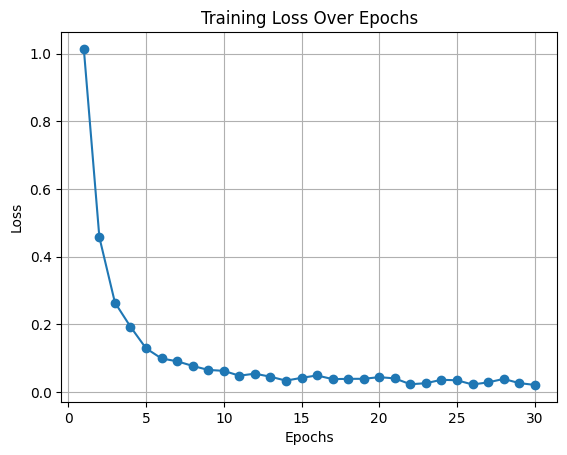

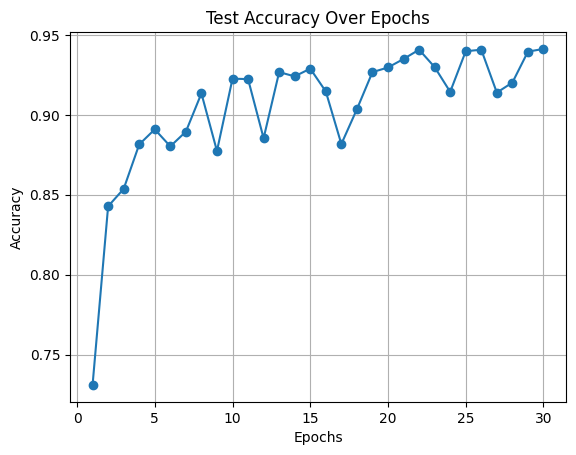

In [45]:
# MULTIMODAL
#loss curve
plt.plot(range(1, len(trainLosses) + 1), trainLosses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
#saves based on modality used
if savingLabel == "MultiModal_EarlyFusion":
    plt.savefig(os.path.join(saveResults, "trainLoss_MultiModal_EarlyFusion.png"))
plt.show()

#accuracy
plt.plot(range(1, len(testAccuracies) + 1), testAccuracies, marker='o')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
#saves based on modalžty used
if savingLabel == "MultiModal_EarlyFusion":
    plt.savefig(os.path.join(saveResults, "testAccuracy_MultiModal_EarlyFusion.png"))
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     23370
           1       0.92      0.94      0.93      6630
           2       0.93      0.90      0.91     10380
           3       0.90      0.90      0.90     36180
           4       0.93      0.85      0.89      3090
           5       0.95      0.96      0.96     26460
           6       0.84      0.83      0.83     17940

    accuracy                           0.90    124050
   macro avg       0.91      0.90      0.90    124050
weighted avg       0.90      0.90      0.90    124050



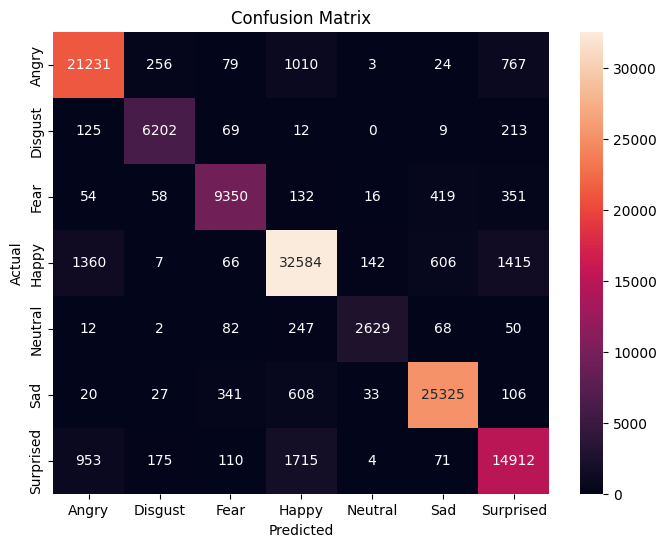

In [48]:
# MULTIMODAL
#confusion matrix and classification report
conf_matrix = confusion_matrix(targetsArr, predictionsArr)

print("\nClassification Report:")
print(classification_report(targetsArr, predictionsArr))
#saves based on modality used
if savingLabel == "MultiModal_EarlyFusion":
    with open(os.path.join(saveResults, "classificationReport_MultiModal_EarlyFusion.txt"), "w") as f:
        f.write(classification_report(targetsArr, predictionsArr))

#visualisation of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classNames, yticklabels=classNames)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_MultiModal_EarlyFusion.png"))
plt.show()

In [ ]:
# Login to wandb - you'll need to enter your API key when prompted
!wandb login

# Sync the specific offline run to upload it to wandb cloud
!wandb sync /content/drive/MyDrive/data/wandb/offline-run-20250830_094941-dndl40p5

In [ ]:
#visualising some images and their labels

#true images and labels
imagesPlot, labelsPlot = next(iter(train_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlot[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
    ax.set_title(classNames[labelsPlot[i]])
    ax.axis('off')
    plt.suptitle('Sample Training Images with True Labels',fontsize=14)
plt.tight_layout()


#predicted images and labels
imagesPlotPred, labelsPlotPred = next(iter(test_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlotPred[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))

    trueLabel = classNames[labelsPlotPred[i]]
    predictedLabel = classNames[predicted[i]]

    ax.set_title(f'True: {trueLabel}\nPredicted: {predictedLabel}')
    ax.axis("off")
    plt.suptitle('Sample Testing Images with True and Predicted Labels',fontsize=14)
plt.tight_layout()